In [1]:
import pandas as pd
import numpy as np
from astropy.cosmology import Planck13
from astropy.io import fits
from astropy.table import Table
from tqdm import tqdm
%matplotlib inline
import matplotlib.pyplot as plt

import disperse

In [2]:
cosmo = Planck13
H0 = cosmo.H0.value
Om = cosmo.Om0
Ol = 0.69288
Ok = 0.0
print(f'H0 = {cosmo.H0.value}')
print(f'Om = {cosmo.Om0}')
print(f'Ol = {0.69288}')

H0 = 67.77
Om = 0.30712
Ol = 0.69288


In [3]:
coma_DR12 = pd.read_csv('coma_DR12_filtered_RaDecZ.csv')
sdss_opt_gr_full = pd.read_csv('sdss_opt_gr_filtered_RaDecZ.csv')

In [4]:
coma_DR12

,RA,DEC,Z
0,247.159333,39.551266,0.031252
1,246.358714,39.870696,0.029112
2,246.920352,39.383022,0.029601
3,246.842087,39.109641,0.033110
4,246.765044,39.527357,0.033841
...,...,...,...
57194,172.000815,25.069872,0.005537
57195,142.900640,27.296280,0.005956
57196,178.705527,6.709595,0.005738
57197,161.946250,46.879323,0.005694


In [5]:
# min_n_gals_ = 6
# sdss_opt_gr_ = sdss_opt_gr_full[sdss_opt_gr_full['n_gal'] >= min_n_gals]

In [6]:
# sdss_opt_gr_

In [7]:
min_n_gals = 6
sdss_opt_gr = sdss_opt_gr_full[sdss_opt_gr_full['n_gal'] >= min_n_gals]
sdss_opt_gr.reset_index(drop=True, inplace=True)
sdss_opt_gr['R'] = sdss_opt_gr['R200']
sdss_opt_gr

<ipython-input-7-e8872c66840f>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sdss_opt_gr['R'] = sdss_opt_gr['R200']


,n_gal,RA,DEC,Z,r_max,M200,R200,R
0,180,246.942018,39.401823,0.031119,1.720684,635.84400,1.794430,1.794430
1,83,247.581739,39.778534,0.028910,1.040201,221.20700,1.262930,1.262930
2,101,246.935701,40.923333,0.031285,1.363890,307.13700,1.407870,1.407870
3,85,247.491124,40.610586,0.029515,1.029668,147.28800,1.102600,1.102600
4,34,246.010700,41.010818,0.030111,1.035922,135.63800,1.072530,1.072530
...,...,...,...,...,...,...,...,...
1041,8,192.086672,29.284369,0.024528,0.497628,29.99220,0.649708,0.649708
1042,6,217.010164,44.883364,0.008886,0.377675,7.78518,0.416487,0.416487
1043,6,175.717709,31.832029,0.006754,0.408784,7.94580,0.419609,0.419609
1044,6,210.070852,61.387018,0.006279,0.418206,10.41250,0.459248,0.459248


In [8]:
DPS = disperse.Disperse3D(
    coma_DR12, '_disperse_03/bin/',
    H0, Om, Ol, Ok,
    clusters=sdss_opt_gr
)

In [9]:
DPS.count_cart_coords()

In [10]:
SIGMA = 5.0
SMOOTH = 1
BOARD = 'smooth'
ANGLE = 30

In [11]:
sigmas = [
         0.2, 0.4, 0.6, 0.8,
    1.0, 1.2, 1.4, 1.6, 1.8,
    2.0, 2.2, 2.4, 2.6, 2.8,
    3.0, 3.2, 3.4, 3.6, 3.8, 
    4.0, 4.2, 4.4, 4.6, 4.8, 
    5.0, 5.2, 5.4, 5.6, 5.8, 
    6.0, 6.2, 6.4, 6.6, 6.8,
    7.0, 7.2, 7.4, 7.6, 7.8,
    8.0
]

In [12]:
# for sigma in sigmas:
#     SIGMA = sigma
#     print('### ', SIGMA)
#     DPS.apply_disperse(SIGMA, SMOOTH, BOARD, ANGLE)
#     DPS.save(f'coma_dumps/{SIGMA}/')

In [13]:
true_cl_dists = []
false_cl_dists = []
for sigma in tqdm(sigmas):
    DPS = disperse.Disperse3D.read(f'coma_dumps/{sigma}/')
    DPS.gen_random_clusters()
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn([3] * DPS.clusters.shape[0])
    true_cl_dists.append(np.array(cl_dists)[None,:])
    cl_conn = np.array(cl_conn)
    
    cl_conn, fil_conn, cl_dists \
        = DPS.count_conn(
            [3] * DPS.clusters.shape[0], 
            DPS.random_clusters[0]
        )
    false_cl_dists.append(np.array(cl_dists)[None,:])

true_dists = np.concatenate(true_cl_dists, axis=0)
false_dists = np.concatenate(false_cl_dists, axis=0)

  0%|          | 0/40 [00:00<?, ?it/s]

>>> Generate random clusters


100%|██████████| 40/40 [00:35<00:00,  1.14it/s]


In [14]:
true_dists.shape

(40, 1046)

In [15]:
(true_dists[-1,:] < 30).sum()

946

In [16]:
np.random.seed(0)
cl_num = 100
cl_idx = np.random.choice(list(range(222)), size=cl_num)

Text(0.5, 1.0, 'TRUE and FALSE clusters (cl_num=100)')

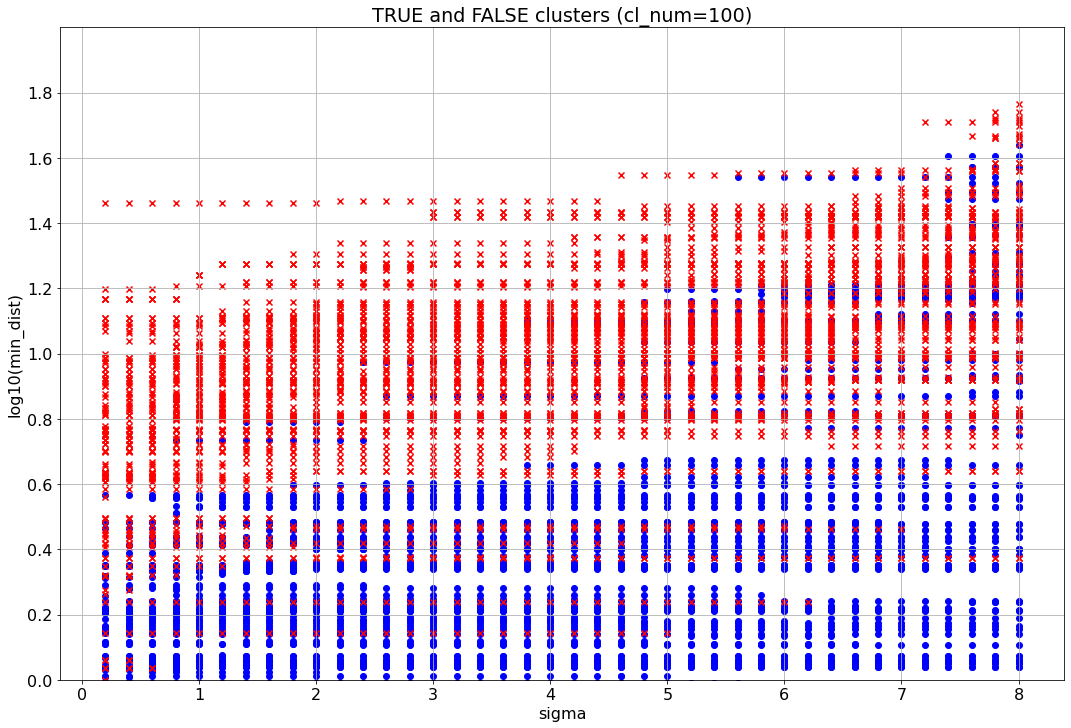

In [17]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 2.0, 0.2))
plt.ylim((0, 2.0))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[:, cl_idx[i]]), c='b', marker='o')
    
for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[:, cl_idx[i]]), c ='r', marker='x')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE and FALSE clusters (cl_num={cl_num})')
# plt.savefig(f'TRUE and FALSE clusters (cl_num={cl_num}).jpg')

Text(0.5, 1.0, 'TRUE clusters (cl_num=100)')

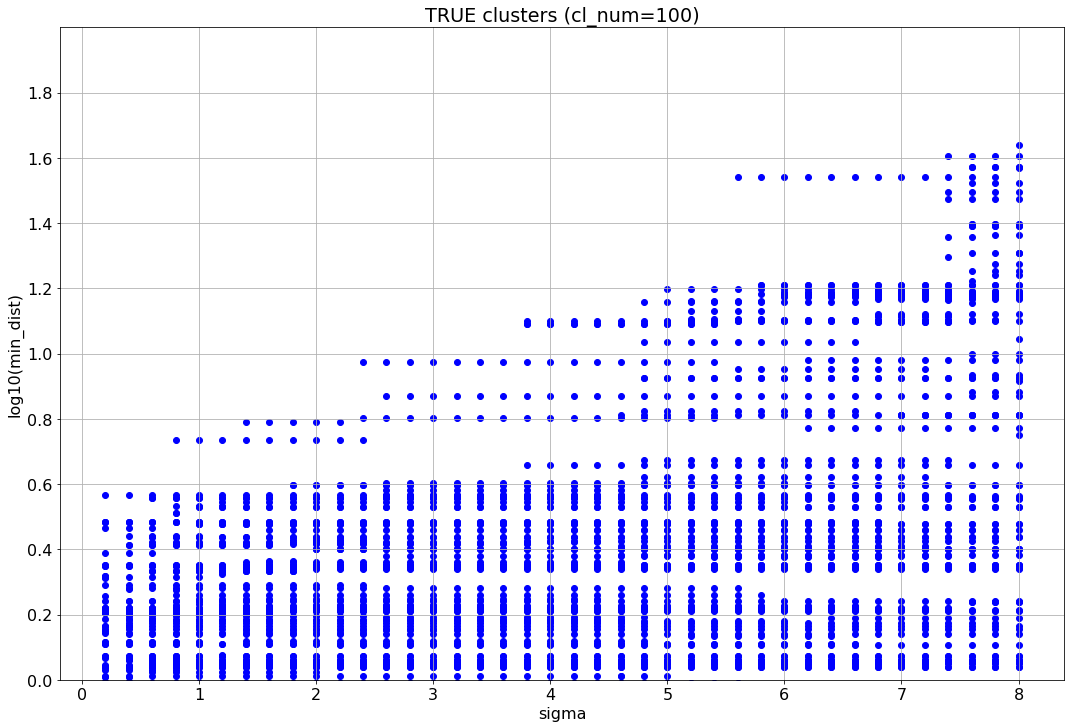

In [18]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 2.0, 0.2))
plt.ylim((0, 2.0))
# plt.yticks(np.arange(0, 70, 10))
# plt.ylim((0, 70))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(true_dists[:, cl_idx[i]]), c='b', marker='o')
    
# for i in range(cl_num):
#     plt.scatter(sigmas, true_dists[:, cl_idx[i]], c='b', marker='o')
    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
# plt.legend()
plt.title(f'TRUE clusters (cl_num={cl_num})')
# plt.savefig(f'TRUE clusters (cl_num={cl_num}).jpg')

Text(0.5, 1.0, 'FALSE clusters (cl_num=100)')

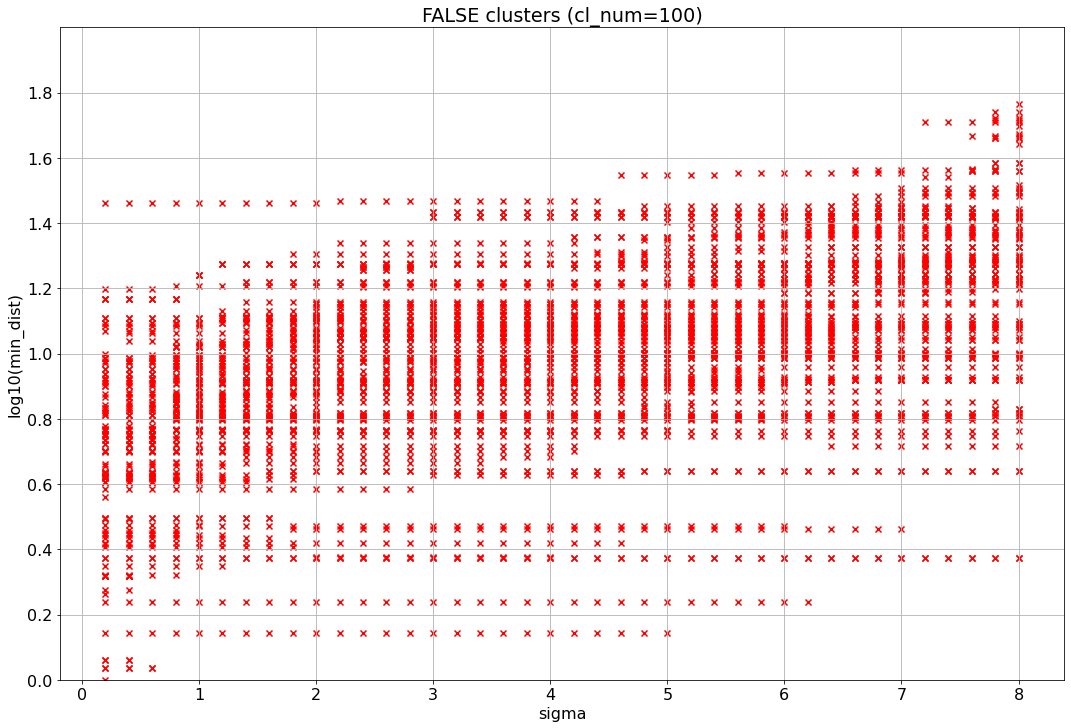

In [19]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.yticks(np.arange(0, 2.0, 0.2))
plt.ylim((0, 2.0))
# plt.yticks(np.arange(0, 70, 10))
# plt.ylim((0, 70))

for i in range(cl_num):
    plt.scatter(sigmas, np.log10(false_dists[:, cl_idx[i]]), c ='r', marker='x')

# for i in range(cl_num):
#     plt.scatter(sigmas, false_dists[:, cl_idx[i]], c ='r', marker='x')

    
plt.xlabel('sigma')
plt.ylabel('log10(min_dist)')
plt.title(f'FALSE clusters (cl_num={cl_num})')
# plt.savefig(f'FALSE clusters (cl_num={cl_num}).jpg')

In [20]:
rads = list(range(1, 11))

In [21]:
# true_sigmas = []
# false_sigmas = []

# for i, rad in enumerate(rads):
#     t = np.zeros(clusters.shape[0])
#     f = np.zeros(clusters.shape[0])
#     for j, sigma in tqdm(enumerate(sigmas)):
#         t[true_dists[:,j] <= rad] = sigma
#         f[false_dists[:,j] <= rad] = sigma

#     true_sigmas.append(t)
#     false_sigmas.append(f)
    
# true_sigmas = np.array(true_sigmas)
# false_sigmas = np.array(false_sigmas)

In [22]:
true_sigmas = []
false_sigmas = []

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    false_sigmas.append([])
    for i, rad in enumerate(rads):
        t = np.zeros(sdss_opt_gr.shape[0])
        f = np.zeros(sdss_opt_gr.shape[0])
        for sigma in tqdm(sigmas):
            DPS = disperse.Disperse3D.read(f'coma_dumps/{sigma}/')
    #         DPS.gen_random_clusters()

            if k == 0:
                cl_conn, fil_conn, cl_dists \
                    = DPS.count_conn([rad] * DPS.clusters.shape[0])
                true_cl_dists.append(np.array(cl_dists)[None,:])
                cl_conn = np.array(cl_conn)
                t[cl_conn > 0] = sigma

            cl_conn, fil_conn, cl_dists \
                = DPS.count_conn(
                    [rad] * DPS.clusters.shape[0], 
                    DPS.random_clusters[k]
                )
            cl_conn = np.array(cl_conn)
            f[cl_conn > 0] = sigma

        if k == 0:
            true_sigmas.append(t)
        false_sigmas[k].append(f)

100%|██████████| 40/40 [00:20<00:00,  1.91it/s]


In [23]:
true_sigmas = np.array(true_sigmas)

In [24]:
true_sigmas

array([[6.8, 5.2, 0. , ..., 2. , 1. , 1.4],
       [6.8, 5.2, 1. , ..., 4.2, 5.6, 2.6],
       [6.8, 6.8, 6.8, ..., 4.2, 5.6, 2.6],
       ...,
       [8. , 6.8, 8. , ..., 8. , 5.6, 8. ],
       [8. , 6.8, 8. , ..., 8. , 5.6, 8. ],
       [8. , 6.8, 8. , ..., 8. , 7. , 8. ]])

In [25]:
false_sigmas = np.array(false_sigmas)

In [26]:
false_sigmas

array([[[0. , 0.2, 0. , ..., 0. , 0. , 0. ],
        [0. , 0.2, 0. , ..., 0. , 0. , 0. ],
        [0. , 0.2, 3.8, ..., 4.6, 1.4, 0. ],
        ...,
        [0.4, 8. , 3.8, ..., 4.6, 1.4, 1. ],
        [1.8, 8. , 8. , ..., 5. , 6.6, 1. ],
        [8. , 8. , 8. , ..., 5. , 6.6, 1. ]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0.4, 0. , ..., 0. , 0. , 0. ],
        [0. , 1. , 0. , ..., 0. , 0. , 4.6],
        ...,
        [0. , 2.8, 0. , ..., 0.6, 0.8, 6.2],
        [0. , 2.8, 0. , ..., 2. , 4. , 6.2],
        [0. , 2.8, 0. , ..., 2. , 4. , 6.2]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0.6, 0. ],
        [0. , 0.4, 0. , ..., 0. , 6.6, 0. ],
        ...,
        [0. , 5. , 1. , ..., 4.8, 6.6, 4.8],
        [1. , 5. , 5.2, ..., 4.8, 6.6, 4.8],
        [1. , 5. , 5.2, ..., 4.8, 6.6, 4.8]],

       [[0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        [0. , 0. , 0. , ..., 0. , 0. , 0. ],
        ..

In [27]:
with open('true_sigmas.npy', 'wb') as f:
    np.save(f, true_sigmas)
with open('false_sigmas.npy', 'wb') as f:
    np.save(f, false_sigmas)

In [28]:
with open('true_sigmas.npy', 'rb') as f:
    true_sigmas = np.load(f)
with open('false_sigmas.npy', 'rb') as f:
    false_sigmas = np.load(f)

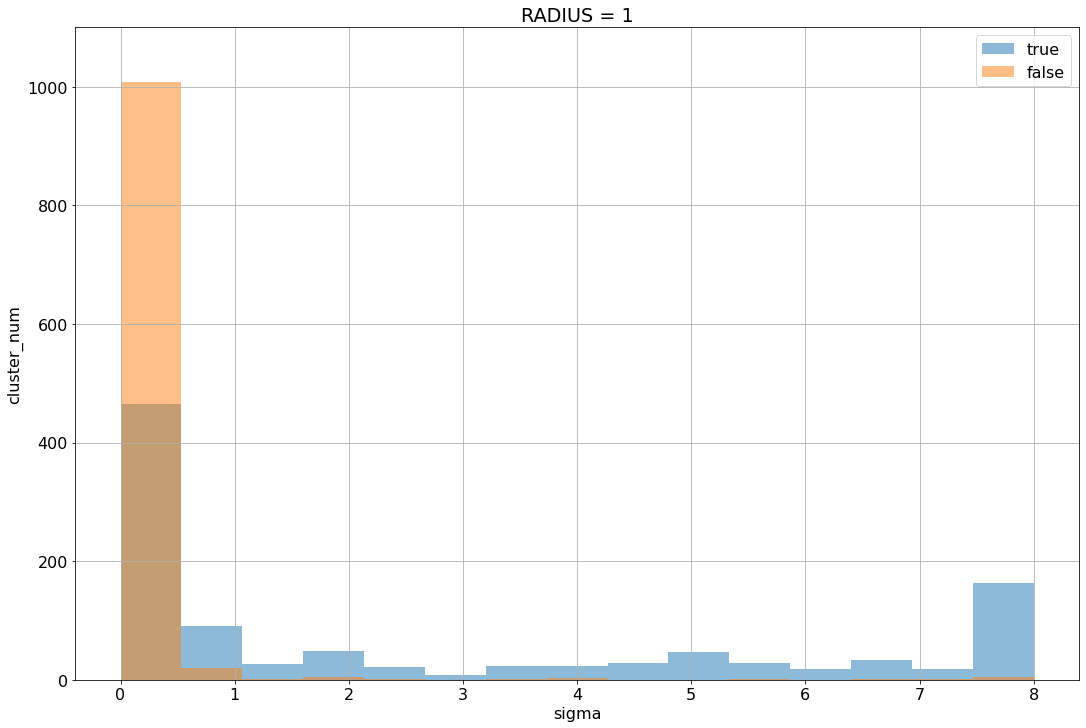

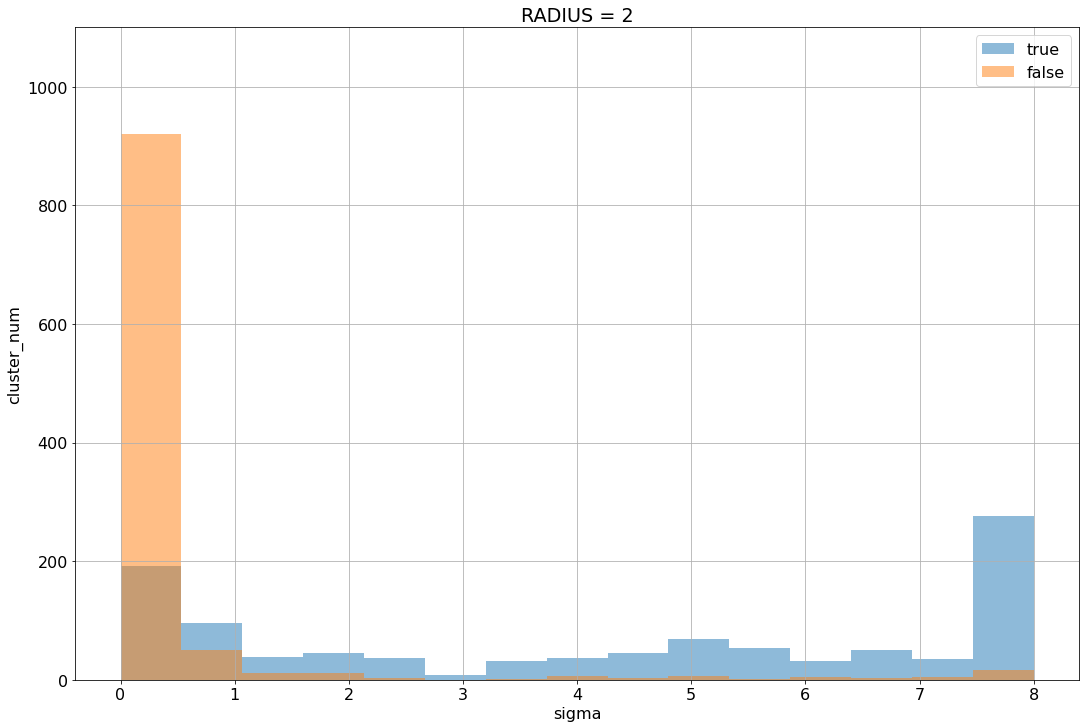

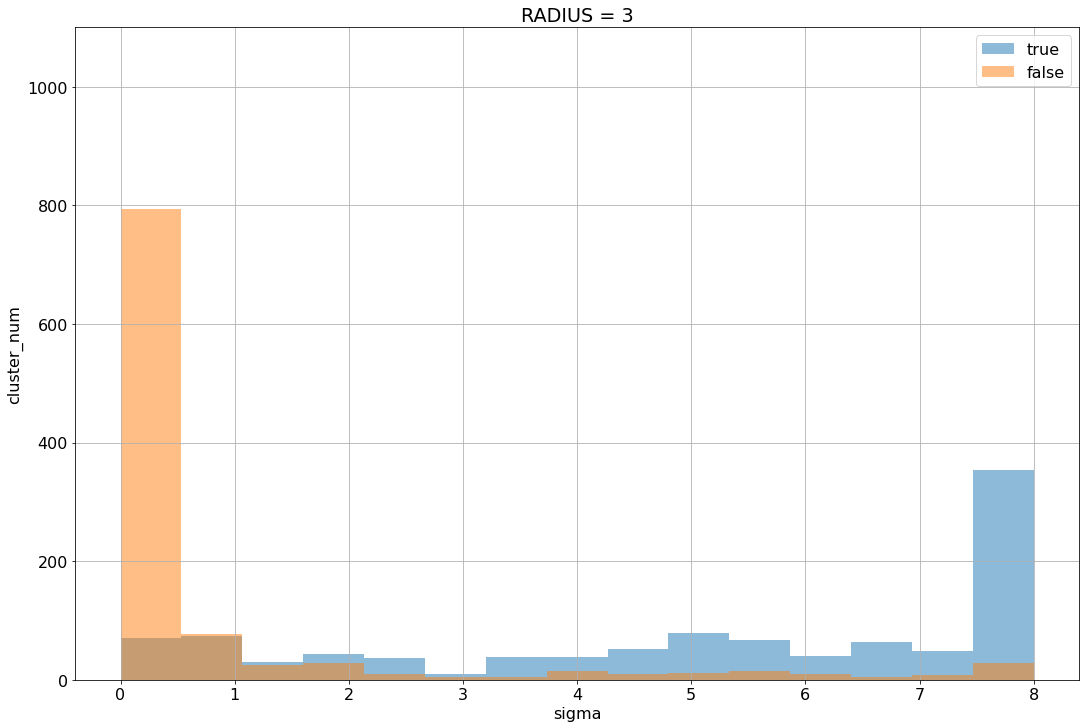

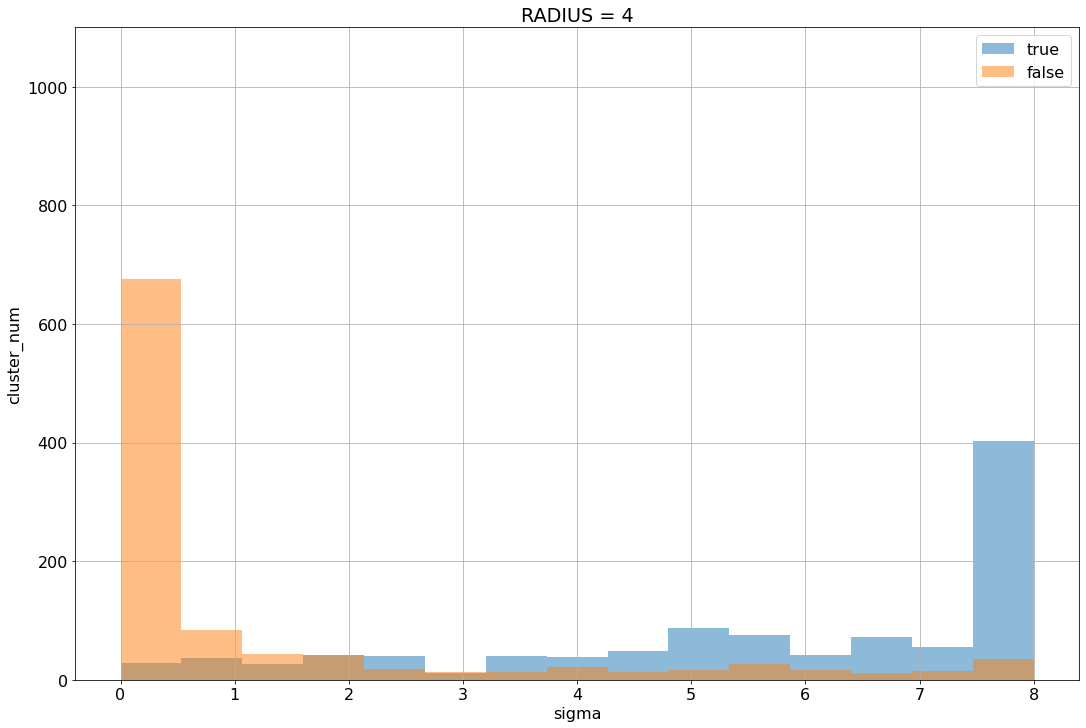

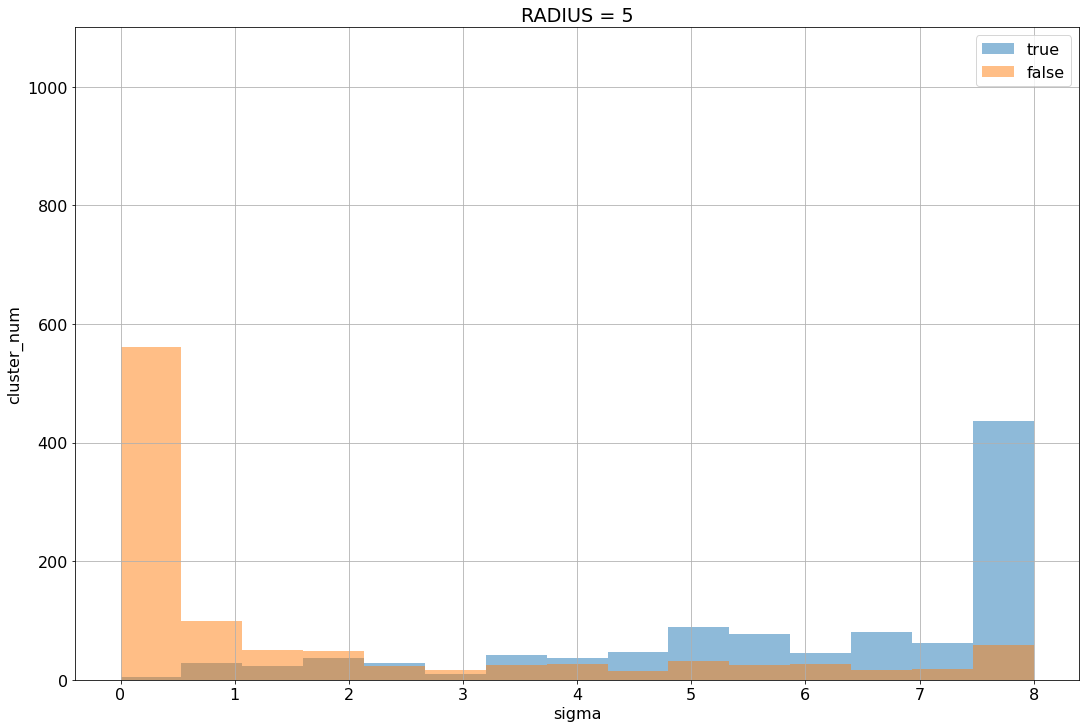

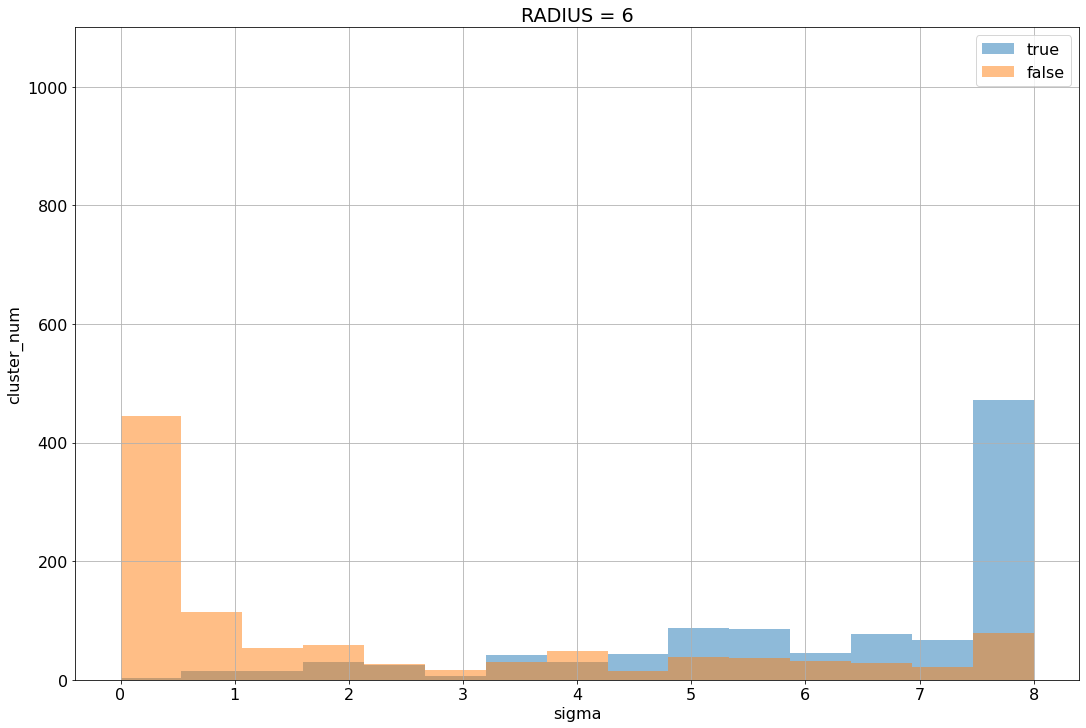

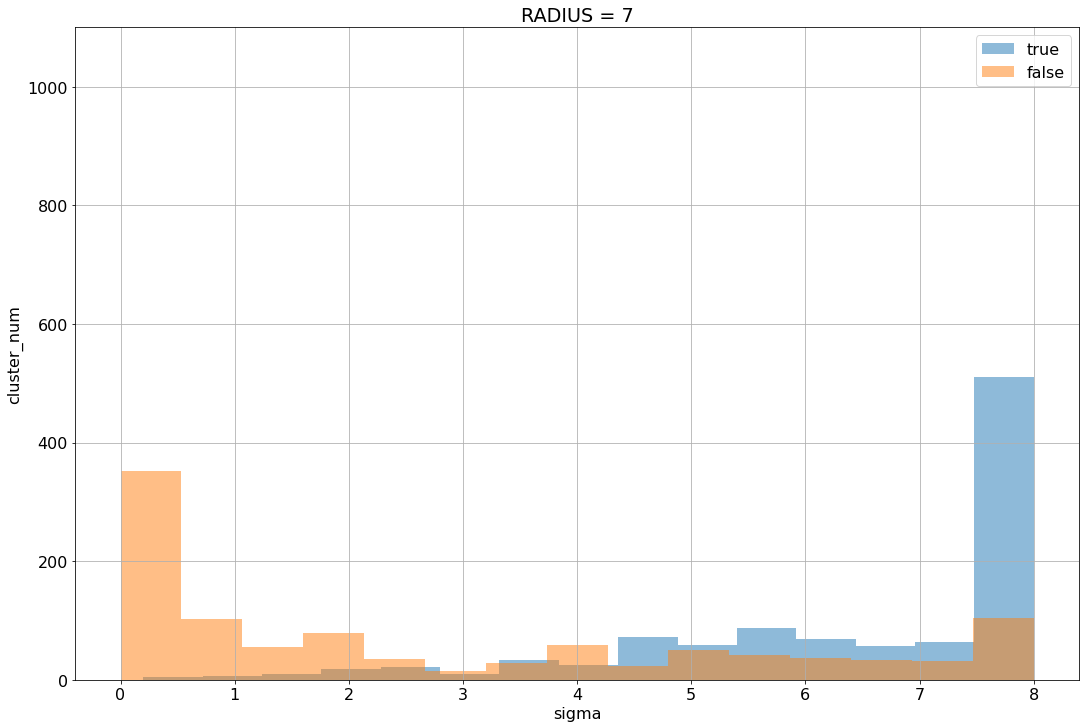

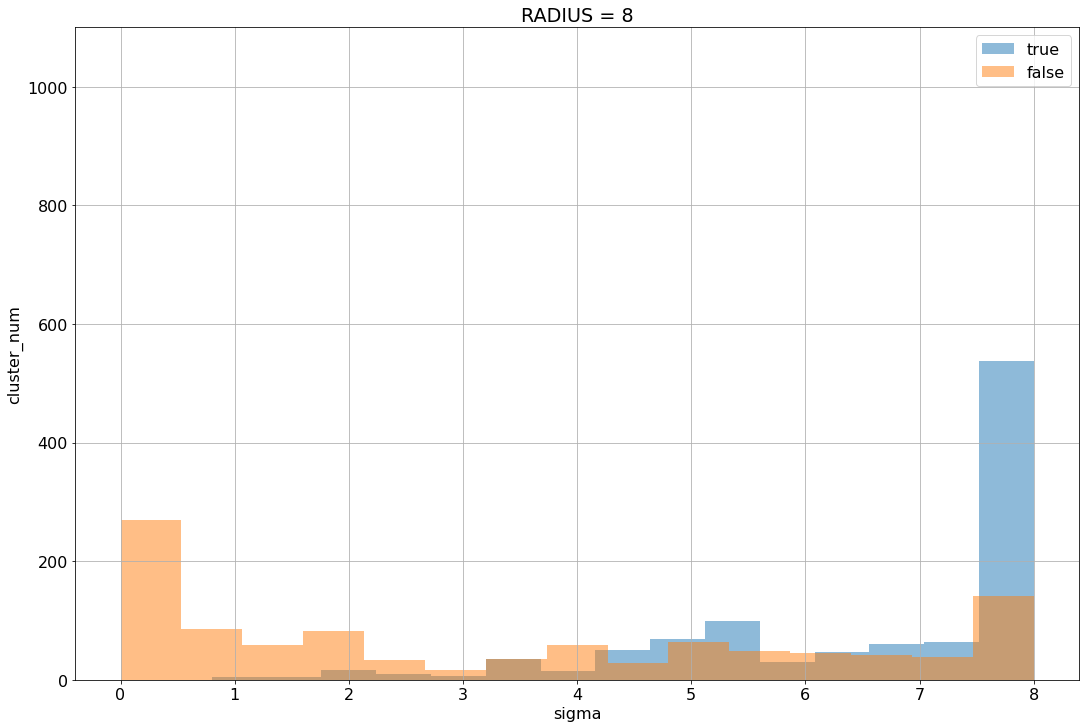

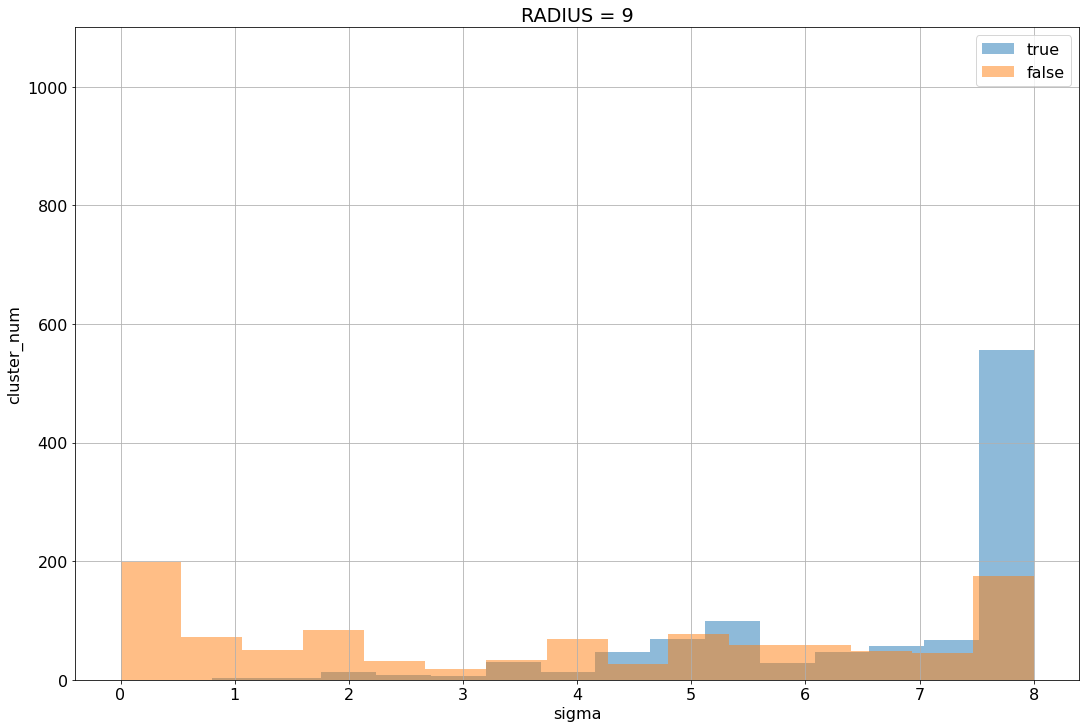

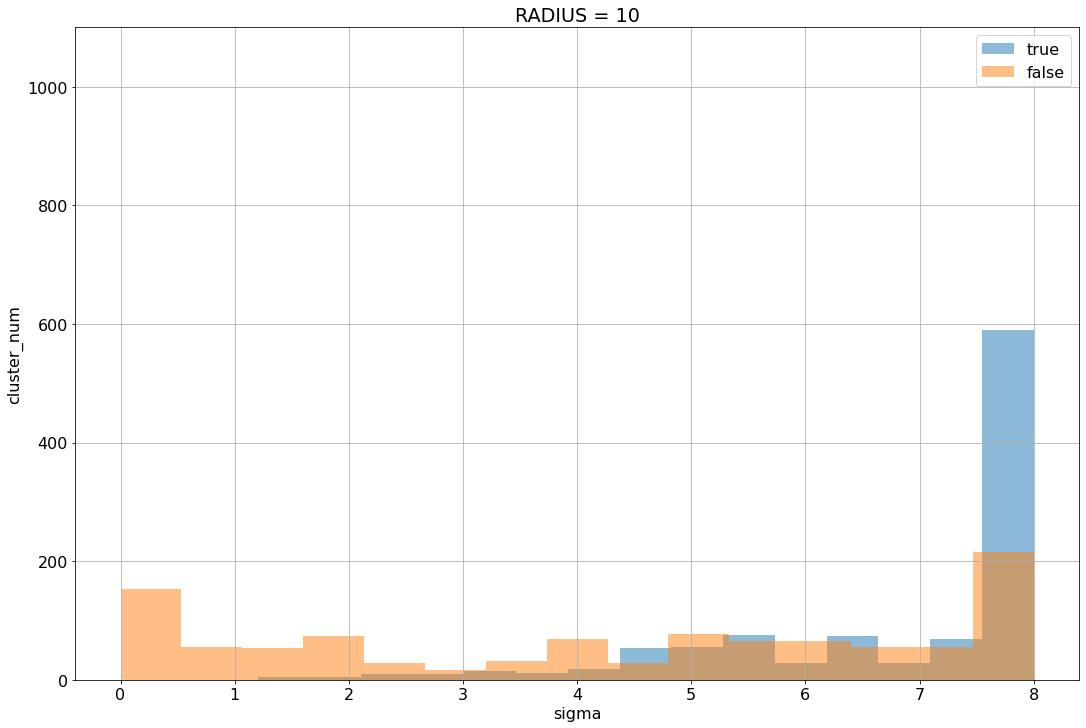

In [29]:
for i, rad in enumerate(rads):
    font = {'size': 16}
    plt.rc('font', **font)
    fig = plt.figure(figsize=(18, 12))
    plt.grid()
    plt.ylim((0, 1100))
    
    plt.hist(true_sigmas[i], density=False, bins=15, alpha=0.5, label='true')
    plt.hist(false_sigmas[0][i], density=False, bins=15, alpha=0.5, label='false')
    plt.xlabel('sigma')
    plt.ylabel('cluster_num')
    plt.legend()
    plt.title(f'RADIUS = {rad}')
#     plt.savefig(f'hists/HIST.RAD={rad}.jpg')

In [30]:
from sklearn.metrics import roc_auc_score

In [31]:
roc_aucs = []
for k in range(DPS.RANDOM_CLUSTERS_NUM):
    roc_aucs.append([])
    for i, rad in enumerate(rads):
        y_true = np.array([1] * sdss_opt_gr.shape[0] + [0] * sdss_opt_gr.shape[0])
        y_scores = np.concatenate((true_sigmas[i], false_sigmas[k][i]))
        roc_aucs[k].append(roc_auc_score(y_true, y_scores))

Text(0.5, 1.0, 'ROC_AUC')

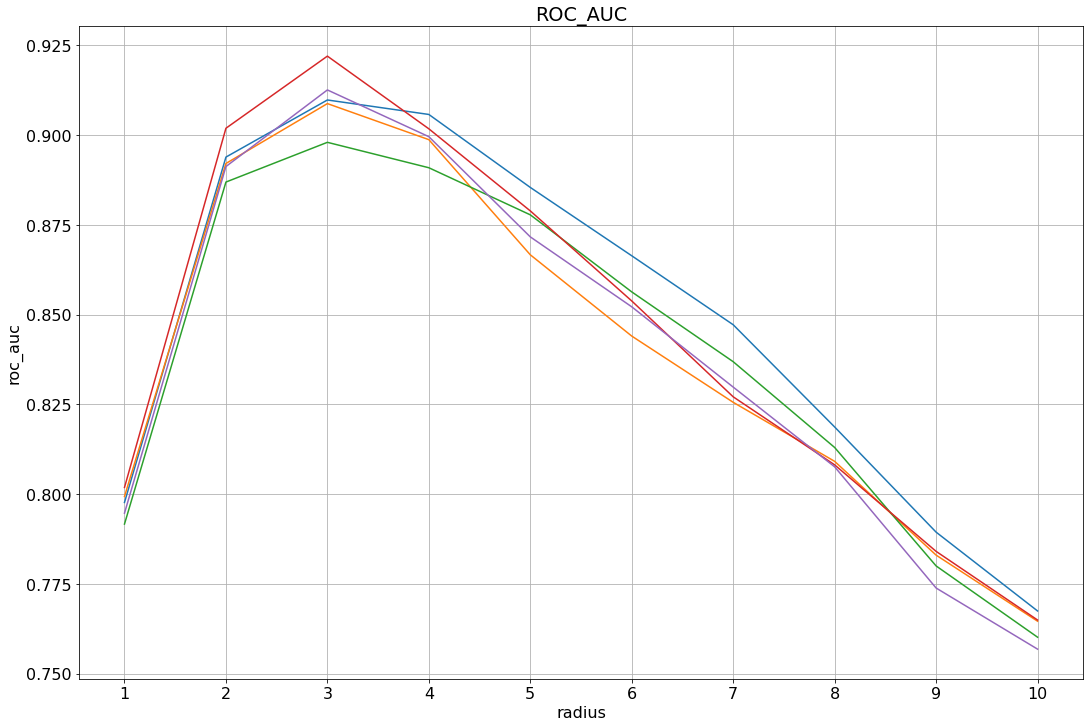

In [32]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()
plt.xticks(list(range(11)))
# plt.yticks(np.arange(0, 66, 5))
# plt.ylim((0, 70))

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(rads, roc_aucs[k])

    
plt.xlabel('radius')
plt.ylabel('roc_auc')
plt.title(f'ROC_AUC')
# plt.savefig(f'ROC_AUC.jpg')

In [33]:
sdss_opt_gr.shape[0]

1046

In [34]:
from sklearn.metrics import roc_curve
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import f1_score

In [35]:
fprs, tprs, thresholds = [], [], []
for k in range(DPS.RANDOM_CLUSTERS_NUM):
    y_true = np.array([1] * sdss_opt_gr.shape[0] + [0] * sdss_opt_gr.shape[0])
    y_scores = np.concatenate((true_sigmas[3], false_sigmas[k][3]))
    fpr, tpr, thrs = roc_curve(y_true, y_scores, pos_label=1)
    fprs.append(fpr)
    tprs.append(tpr)
    thresholds.append(thrs)

Text(0.5, 1.0, 'ROC')

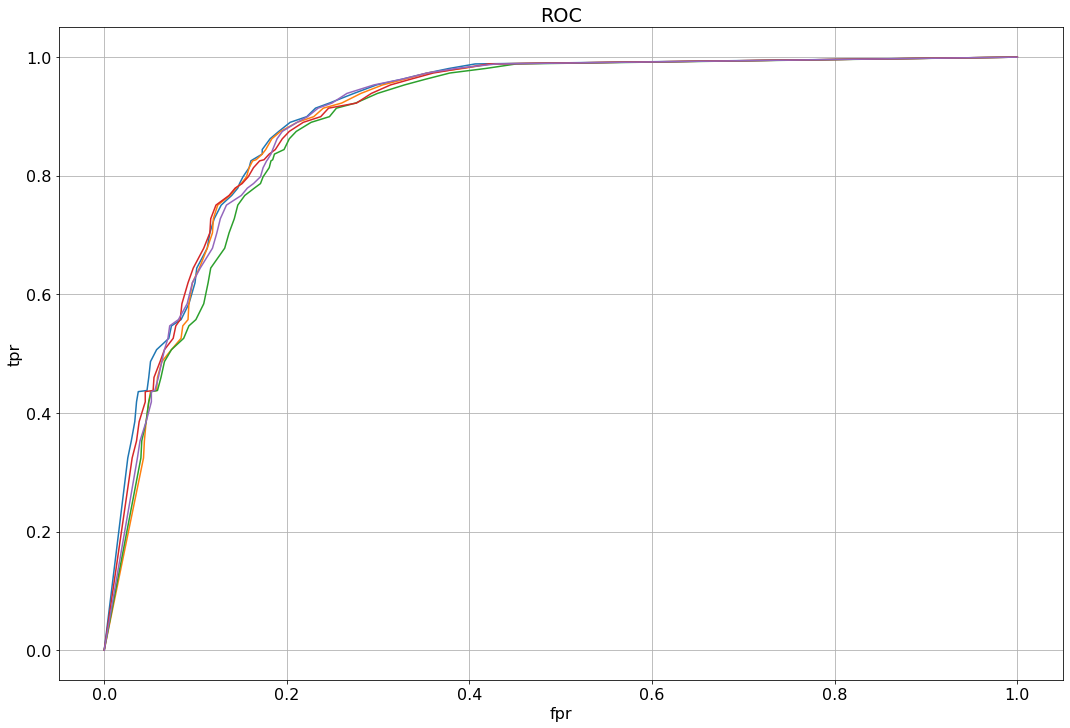

In [36]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(fprs[k], tprs[k], label=f'{k}')

# plt.legend()
plt.xlabel('fpr')
plt.ylabel('tpr')
plt.title(f'ROC')
# plt.savefig(f'ROC.jpg')

In [37]:
precisions, recalls, thresholds = [], [], []
for k in range(DPS.RANDOM_CLUSTERS_NUM):
    y_true = np.array([1] * sdss_opt_gr.shape[0] + [0] * sdss_opt_gr.shape[0])
    y_scores = np.concatenate((true_sigmas[3], false_sigmas[k][3]))
    prec, recall, thrs = precision_recall_curve(y_true, y_scores, pos_label=1)
    precisions.append(prec)
    recalls.append(recall)
    thresholds.append(thrs)

Text(0.5, 1.0, 'Precision')

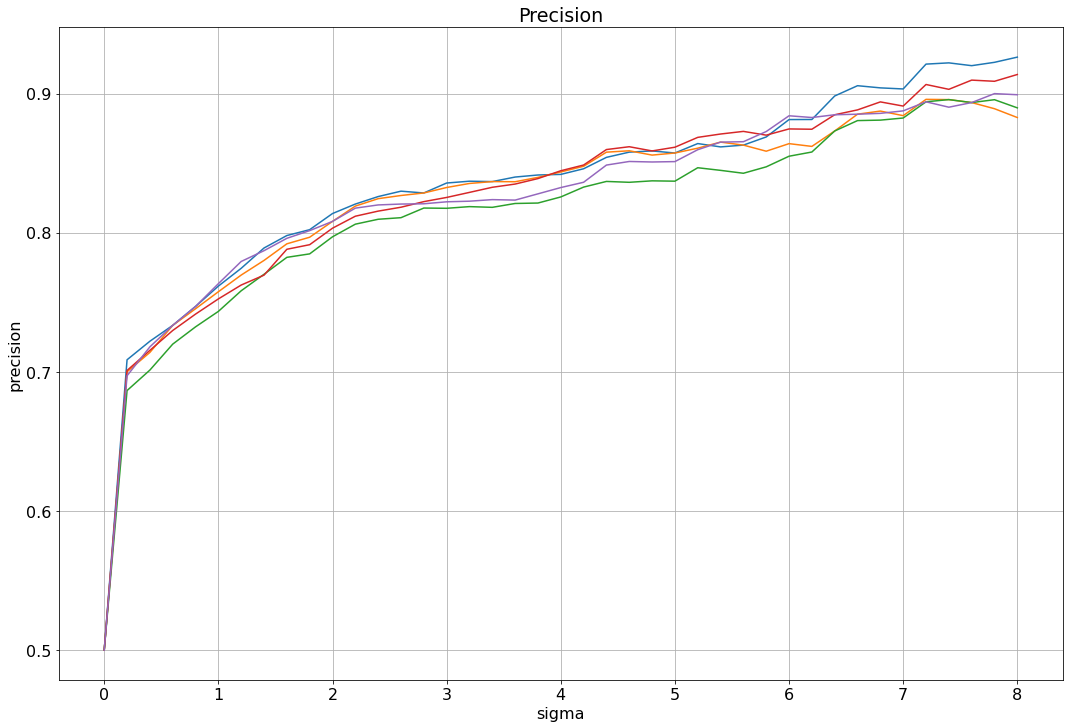

In [38]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(thresholds[k], precisions[k][:-1])

plt.xlabel('sigma')
plt.ylabel('precision')
plt.title(f'Precision')
# plt.savefig(f'Precision.jpg')

Text(0.5, 1.0, 'Recall')

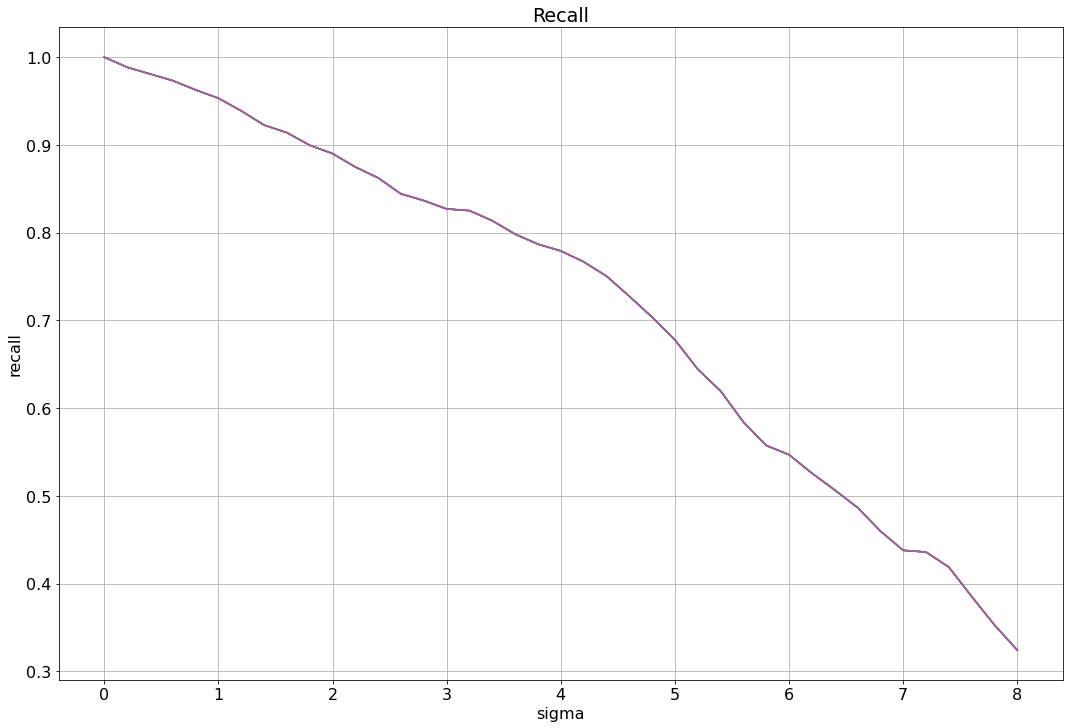

In [39]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(thresholds[k], recalls[k][:-1])

plt.xlabel('sigma')
plt.ylabel('recall')
plt.title(f'Recall')
# plt.savefig(f'Recall.jpg')

In [40]:
precisions = np.array(precisions)
recalls = np.array(recalls)

In [41]:
f1 = 2 * precisions * recalls / (precisions + recalls)

Text(0.5, 1.0, 'F1-score')

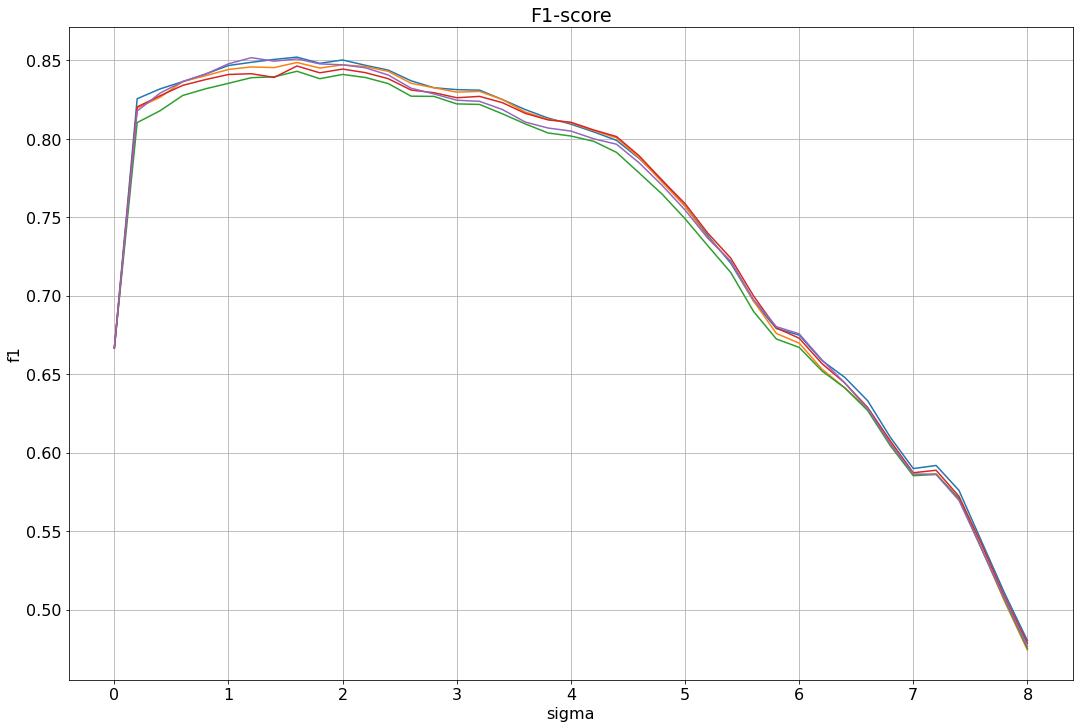

In [42]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(thresholds[k], f1[k][:-1])

plt.xlabel('sigma')
plt.ylabel('f1')
plt.title(f'F1-score')
# plt.savefig(f'F1-score.jpg')

Text(0.5, 1.0, 'PREC-RECALL')

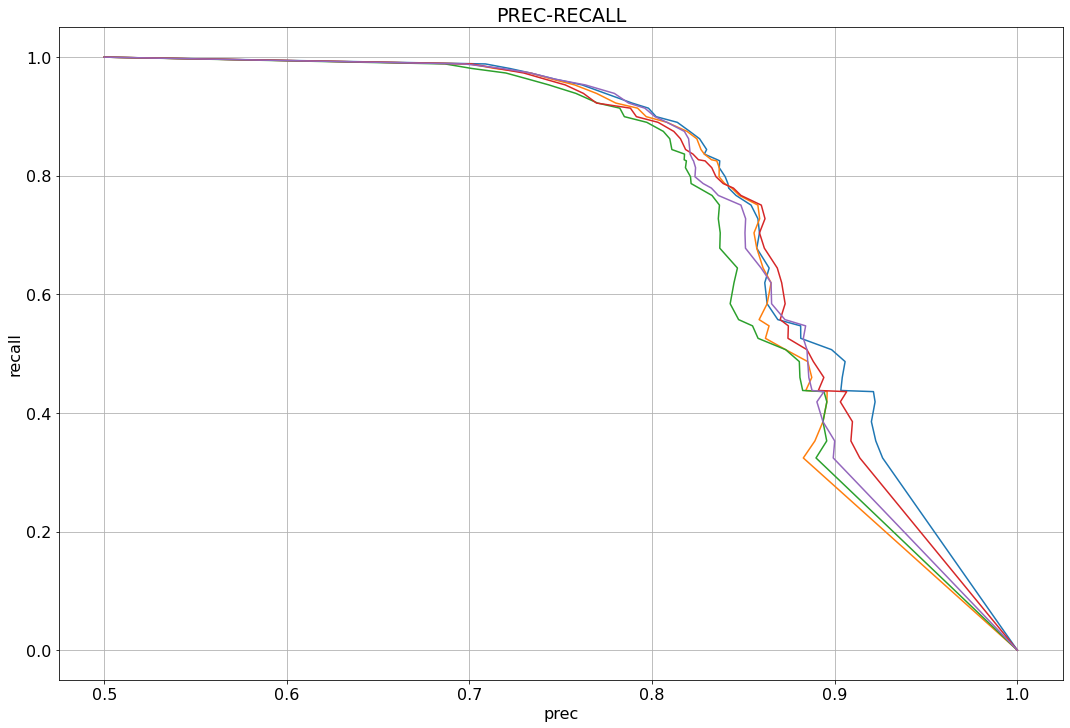

In [43]:
font = {'size': 16}
plt.rc('font', **font)
fig = plt.figure(figsize=(18, 12))
plt.grid()

for k in range(DPS.RANDOM_CLUSTERS_NUM):
    plt.plot(precisions[k], recalls[k])

plt.xlabel('prec')
plt.ylabel('recall')
plt.title(f'PREC-RECALL')
# plt.savefig(f'PREC-RECALL.jpg')